<a href="https://colab.research.google.com/github/savithrikb/dl-photo-restoration/blob/master/photo_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PHOTO RESTORATION USING RNN's**

In this notebook, we're going to define and train a CycleGAN to read in an image from a set 𝑋 and transform it so that it looks as if it belongs in set 𝑌 . Specifically, we'll look at a set of images that might be damaged, has lower resolution, and dull colors (older photos) as well as a set of high-quality, high-resolution images with bright colors (newer photos).

**LOAD AND VISUALIZE THE DATA**

Next, we have to load and visualize the training data. In order to do so we have to import certain libraries and modules.

In [0]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Dataloader**

*We* have created function return dataloaders that can load data efficiently and in specified batches. This function is also responsible for making sure our images are of the right, square size (512x512x3) and converted into Tensor image types.

In [0]:
def get_data_loader(image_type, image_dir='gdrive/My Drive/photo_restoration/photos', 
                    image_size=512, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'old' or 'new'. 
       These images will be resized to 512x512x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(512),
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    

    return train_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X = get_data_loader(image_type='old')
dataloader_Y = get_data_loader(image_type='new')

**Display training images**

Defining a function to show the images as a grid that contains a batch of image data from set  𝑋 . The function will reshape some given images and converts them to NumPy images so that they can be displayed by plt.



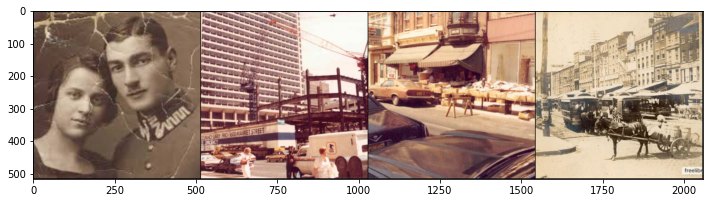

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

showing the images as a grid that contains a batch of image data from set y.

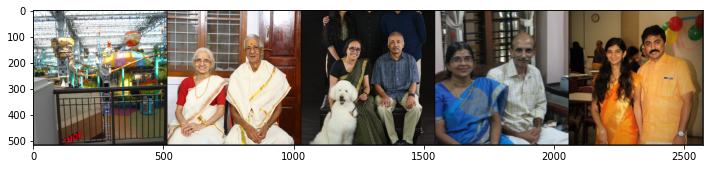

In [0]:

dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

**Pre-processing: scaling from -1 to 1**

We need to do a bit of pre-processing; we know that the output of our tanh activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [0]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [0]:

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


# Define the model
The CycleGan has a generator and a discrimator. The generator will  generate fake images to trick the discriminator, while the discriminator will try to distinguish the generated results from
real data.

## Discriminator
The discrminators attempt to classify the data as real or fake. Therefore real is indicated by an output close to 1 and fake as close to 0.

We used similiar architecture of the paper [Unsupervised Image Super-Resolution
using Cycle-in-Cycle Generative Adversarial Networks](http://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w13/Yuan_Unsupervised_Image_Super-Resolution_CVPR_2018_paper.pdf) for both discriminator and generator.

This network sees a 512x512x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function with negative slope 0.2 applied to their output, and the last acts as a classification layer that outputs one value.




In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Creating a discrimator class to define all convolutional layers and feedforward behavior.

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim = 64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4)
        self.conv5 = conv(conv_dim * 8, 1, 4, stride = 1, batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        output = F.relu(self.conv1(x))
        output = F.relu(self.conv2(output))
        output = F.relu(self.conv3(output))
        output = F.relu(self.conv4(output))
        output = self.conv5(output)
        return output